## Yield Spread model
This notebook implements a model to predict yield spreads from reference and trade history data. The model uses an attention layer between the two LSTM layers.

Last modification: Implementing the improvements suggested by Charles

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os

import wandb
from wandb.keras import WandbCallback


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data

Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
tf.__version__

'2.7.0'

Setting the environment variables

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="eng-reactor-287421-112eb767e1b3.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [4]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [5]:
storage_client = storage.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

#### Initializing Wandb

In [7]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'Alternative attention notebook'
os.environ["WANDB_SILENT"] = "true"

In [8]:
wandb.init(project="yield_spread_model", entity="ficc-ai", name="alternative_attention")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Alternative attention notebook.


#### Query to fetch data

We create the training data from the trades which occurred between July and October 2021. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to bonds whose yield is a positive number less than three. The maturity description code is restricted to 2, to remove all muni derivatives.



In [9]:
DATA_QUERY = ''' 
SELECT
  *
FROM
  `eng-reactor-287421.auxiliary_views.materialized_trade_history`
WHERE
  yield IS NOT NULL
  AND yield > 0
  AND par_traded >= 10000
  AND trade_date >= '2021-04-29'
  --AND trade_date <= '2022-03-23'
  AND maturity_description_code = 2
  AND coupon_type in (8, 4, 10)
  AND capital_type <> 10
  AND default_exists <> TRUE
  AND sale_type <> 4
  AND sec_regulation IS NULL
  AND most_recent_default_event IS NULL
  AND default_indicator IS FALSE
  AND DATETIME_DIFF(trade_datetime,recent[SAFE_OFFSET(0)].trade_datetime,SECOND) < 1000000 -- 12 days to the most recent trade
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_datetime DESC ''' 

#### Fetching data
 
We download the data from the [ficc_training_data_latest](https://console.cloud.google.com/storage/browser/ficc_training_data_latest;tab=objects?authuser=1&project=eng-reactor-287421&prefix=&forceOnObjectsSortingFiltering=true) bucket

In [10]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('ficc_training_data_latest/processed_data.pkl') as f:
    data = pd.read_pickle(f)

#### Additionals exclusion we are working on. This is to eliminate weird cusips

In [11]:
data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
data = data[data.sinking == False]
data = data[data.incorporated_state_code != 'VI']
data = data[data.coupon_type == 8]
data = data[data.is_called == False]

### Adding target trade features to calculate attention

As a first step, we only utilize the size of the trade and the directions as features to calculate the attention. Going forward we will be adding more features like the state code, coupon, interest payment frequency, etc. 

In [12]:
trade_mapping = {'D':[0,0], 'S':[0,1], 'P':[1,0]}
def target_trade_processing_for_attention(row):
    target_trade_features = []
    target_trade_features.append(row['quantity'])
    target_trade_features = target_trade_features + trade_mapping[row['trade_type']]
    return np.tile(target_trade_features, (5,1))

In [13]:
%%time
data['target_attention_features'] = data.apply(target_trade_processing_for_attention, axis = 1)

CPU times: user 5min, sys: 8.92 s, total: 5min 9s
Wall time: 5min 9s


In [14]:
data.iloc[0]['target_attention_features']

array([[4.87506104, 0.        , 1.        ],
       [4.87506104, 0.        , 1.        ],
       [4.87506104, 0.        , 1.        ],
       [4.87506104, 0.        , 1.        ],
       [4.87506104, 0.        , 1.        ]])

#### Concatenating the trade history and target attention features

In [15]:
data['concatenated_trade_history'] = data.apply(lambda x: np.concatenate((x['trade_history'], x['target_attention_features']), axis=1), axis=1)

For the purpose of plotting, not used in training

In [16]:
data.purpose_sub_class.fillna(0, inplace=True)

In [17]:
np.unique(data.rating)

array(['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB',
       'BB+', 'BB-', 'BBB', 'BBB+', 'BBB-', 'CCC', 'CCC+', 'MR', 'NR'],
      dtype=object)

Selecting a subset of features that will be used to train on.

In [18]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

In [19]:
processed_data = data[IDENTIFIERS + PREDICTORS + ['dollar_price','calc_date', 'trade_date','trade_datetime', 'purpose_sub_class', 'called_redemption_type', 'calc_day_cat','concatenated_trade_history']]

These sub classes are associated with junk bonds. We drop them for now.

In [20]:
processed_data = processed_data[~processed_data.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 90, 106])]

In [21]:
processed_data = processed_data[~processed_data.called_redemption_type.isin([18, 19])]

In [22]:
len(processed_data)

2401543

In [23]:
np.unique(processed_data.rating)

array(['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB',
       'BB+', 'BB-', 'BBB', 'BBB+', 'BBB-', 'CCC', 'MR', 'NR'],
      dtype=object)

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [24]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

In [25]:
upload_data(storage_client, 'ficc_training_data_latest', f"encoders.pkl")

File encoders.pkl uploaded to ficc_training_data_latest.


#### Splitting the data into train and test sets



In [26]:
len(processed_data)

2401543

In [27]:
train_dataframe = processed_data[(processed_data.trade_date < '05-01-2022')]

In [28]:
test_dataframe = processed_data[(processed_data.trade_date >= '05-01-2022')]

In [29]:
len(train_dataframe)

1846402

In [30]:
len(test_dataframe)

555141

In [31]:
# train_index = int(len(processed_data) * (1-TRAIN_TEST_SPLIT))
# train_dataframe = processed_data[train_index:]
# # train_security_descrip = security_description_vectorized[train_index:]
# # train_org_primary = organization_primary_vectorized[train_index:]

# test_dataframe = processed_data[:train_index]
# # test_security_descrip = security_description_vectorized[:train_index]
# # test_org_primary = organization_primary_vectorized[:train_index]
# print(f'Print length of training data frame {len(train_dataframe)}')
# print(f'Pring length of testing data frame {len(test_dataframe)}')

Converting data into format suitable for the model

In [32]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['concatenated_trade_history'].to_numpy()))
#     datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [33]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.yield_spread

CPU times: user 3.79 s, sys: 188 ms, total: 3.98 s
Wall time: 3.98 s


In [34]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.yield_spread

CPU times: user 1.15 s, sys: 28.2 ms, total: 1.18 s
Wall time: 1.18 s


In [35]:
x_train[1].shape

(1846402, 26)

In [36]:
x_test[2].shape

(555141,)

#### Adapting Normalization layers to the non categorical features

In [37]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0])

In [38]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[1])

#### Setting the seed for the model

In [39]:
tf.keras.utils.set_random_seed(10)

#### Non-linear encoding block

In [40]:
class NonLinearEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_units_layer_1, hidden_units_layer_2):
        super(NonLinearEncodingLayer, self).__init__()

        self.layer1 = layers.Dense(hidden_units_layer_1,
                                  activation='relu',
                                  name="encoding_layer_1")
        
        self.layer2 = layers.Dense(hidden_units_layer_2,
                                   activation='relu',
                                  name="encoding_layer_2")

    def call(self, concatinated_trade_history):
        return(self.layer2(self.layer1(concatinated_trade_history)))
        
        

#### Attention layer
This is an implementation of a layer that calculates scaled dot product attention. 

In [41]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        #Explicitly specifying the initializer so as to avoid setting the same seed
        self.wq = layers.Dense(depth,
                               name='weights_query') 
        self.wk = layers.Dense(depth,
                               name='weights_key')
        self.wv = layers.Dense(depth,
                               name='weights_value')

    def scaled_dot_product_attention(self, q, v, k):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v, k):
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)

        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model

In [42]:
inputs = []
layer = []

############## INPUT BLOCK ###################
# trade_history_input = layers.Input(name="trade_history_input", 
#                                    shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
#                                    dtype = tf.float32) 

concatenated_trade_history_input = layers.Input(name="concatenated_trade_history", 
                                   shape=(SEQUENCE_LENGTH, 8), 
                                   dtype = tf.float32) 


inputs.append(concatenated_trade_history_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[1]))
####################################################


############## TRADE HISTORY MODEL #################

non_linear_encoding_layer = NonLinearEncodingLayer(100,30)

lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         return_sequences = True,
                         name='LSTM')

# lstm_attention_layer = layers.Attention(use_scale=True, name='attention_layer_1')
lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           return_sequences = False,
                           name='LSTM_2')

features = non_linear_encoding_layer(trade_history_normalizer(inputs[0]))
features = lstm_layer(features)
features = lstm_attention_layer(features, features, features)
features = layers.BatchNormalization()(features)

features = lstm_layer_2(features)
features = layers.BatchNormalization()(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu',)(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = np.max([30,int(np.sqrt(fmax[f]))]),
                                                                    input_length= 1,
                                                                    name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,
                                 activation='relu',
                                 name='reference_hidden_2')(reference_hidden)

reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100, 
                                activation='tanh', 
                                name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,
                      activation='relu')(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,
                       activation='tanh',)(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

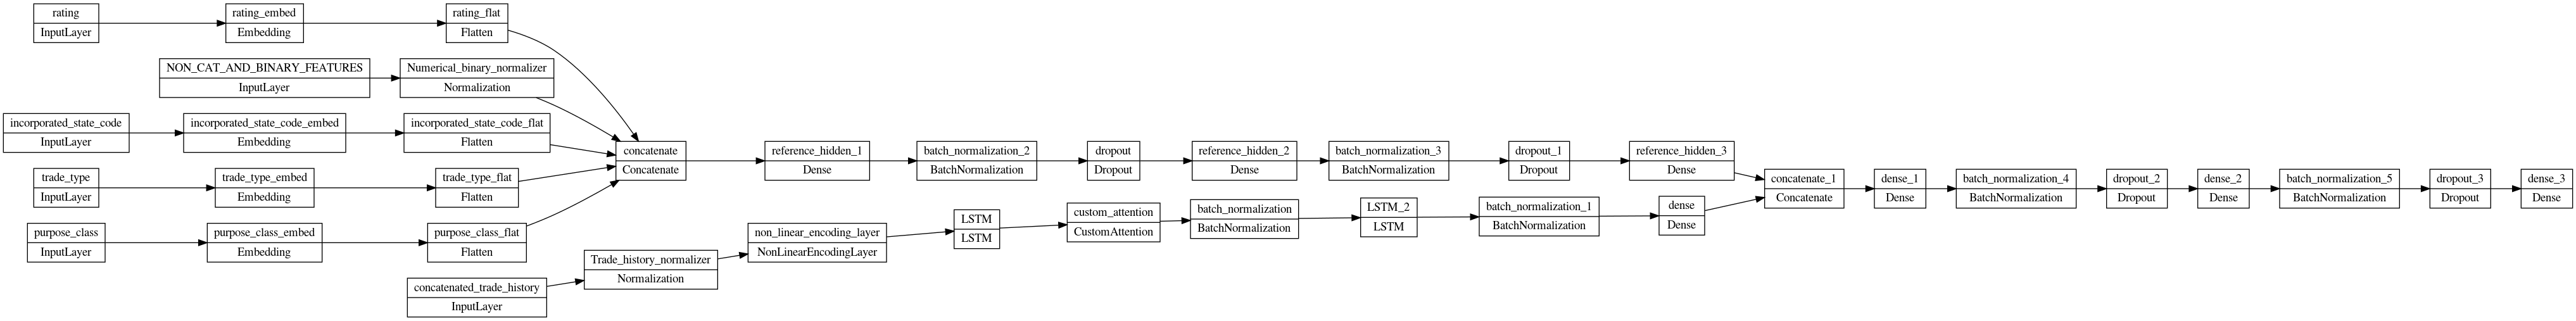

In [44]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [45]:
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [46]:
fit_callbacks = [
    WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [47]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [48]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=1000, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks)

Epoch 1/100
1662/1662 [==============================] - 26s 12ms/step - loss: 39.1629 - mean_absolute_error: 39.1629 - val_loss: 31.2645 - val_mean_absolute_error: 31.2645 - _timestamp: 1655486473.0000 - _runtime: 793.0000
Epoch 2/100
1662/1662 [==============================] - 19s 11ms/step - loss: 26.9956 - mean_absolute_error: 26.9956 - val_loss: 14.9844 - val_mean_absolute_error: 14.9844 - _timestamp: 1655486492.0000 - _runtime: 812.0000
Epoch 3/100
1662/1662 [==============================] - 19s 11ms/step - loss: 12.4041 - mean_absolute_error: 12.4041 - val_loss: 7.0140 - val_mean_absolute_error: 7.0140 - _timestamp: 1655486511.0000 - _runtime: 831.0000
Epoch 4/100
1662/1662 [==============================] - 19s 11ms/step - loss: 8.6895 - mean_absolute_error: 8.6895 - val_loss: 6.8537 - val_mean_absolute_error: 6.8537 - _timestamp: 1655486529.0000 - _runtime: 849.0000
Epoch 5/100
1662/1662 [==============================] - 19s 11ms/step - loss: 8.5043 - mean_absolute_error: 8

### Test accuracy on the entire test set

In [49]:
_, mae = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {round(mae, 3)}")
wandb.log({"Test MAE": mae})

17349/17349 [==============================] - 71s 4ms/step - loss: 11.1596 - mean_absolute_error: 11.1596
Test loss: 11.16


#### Gigaflops for one epoch of training

In [52]:
avg_time = np.mean(time_callback.times)

In [53]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

206.29611147834248


#### Plotting validation loss vs training loss

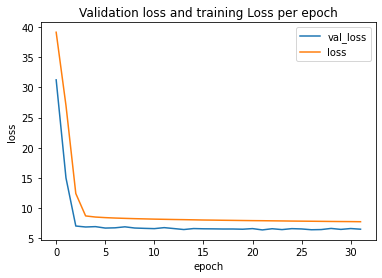

In [54]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Accuracy on a daily basis

Measuring the daily accuracy for large dealer dealer trades

In [55]:
for d in [d for d in pd.date_range(start="05/01/2022",end="05/31/2022",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)
                              & (test_dataframe.trade_type == 'D')
                             & (test_dataframe.quantity >= np.log10(500000))].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test)
    error = next_day.yield_spread - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2022-05-02 MAE:6.460597626367078
Date :2022-05-03 MAE:6.618798316758782
Date :2022-05-04 MAE:7.246937085620424
Date :2022-05-06 MAE:10.692739967512612
Date :2022-05-09 MAE:7.638923743776851
Date :2022-05-10 MAE:8.796897044920293
Date :2022-05-11 MAE:9.477259313161875
Date :2022-05-12 MAE:8.449887890344154
Date :2022-05-13 MAE:10.319809478905556
Date :2022-05-16 MAE:7.5189653727942085
Date :2022-05-17 MAE:7.6165015567372585
Date :2022-05-18 MAE:9.910579187741757
Date :2022-05-19 MAE:7.94078100745908
Date :2022-05-20 MAE:11.047727023329665
Date :2022-05-23 MAE:8.623294136627425
Date :2022-05-24 MAE:11.2167301896311
Date :2022-05-25 MAE:11.178259263235082
Date :2022-05-26 MAE:7.687822908939332
Date :2022-05-27 MAE:13.521254335249653
Date :2022-05-31 MAE:12.566534454145923


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [56]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))] # & (test_dataframe.days_to_call >= np.log10(360))]

In [57]:
len(true_mid)

6193

In [58]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.yield_spread

CPU times: user 24.2 ms, sys: 0 ns, total: 24.2 ms
Wall time: 23.3 ms


In [59]:
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1)
print(f"Test MAE dealer-dealer true mid: {round(mae, 3)}")


194/194 [==============================] - 1s 4ms/step - loss: 9.6324 - mean_absolute_error: 9.6324
Test MAE dealer-dealer true mid: 9.632


### Alternative evaluation set
Experiment with other conditions. From the error analysis notebook, it was observed that the number of accrued days that have passed since the beginning of interest being accrued is important

In [60]:
temp_test = test_dataframe[(test_dataframe['accrued_days'] < 200) & (test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(50000))]

In [61]:
len(temp_test)

7080

In [62]:
%%time
x_temp_test = create_input(temp_test)
y_temp_test = temp_test.yield_spread

CPU times: user 26.1 ms, sys: 213 µs, total: 26.4 ms
Wall time: 25.5 ms


In [63]:
_, mae = model.evaluate(x_temp_test, y_temp_test, verbose=1)
print(f"Test MAE: {round(mae, 3)}")
wandb.log({"Test MAE alternative set": mae})

222/222 [==============================] - 1s 4ms/step - loss: 9.0193 - mean_absolute_error: 9.0193
Test MAE: 9.019


# Saving the model

In [64]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders_{file_timestamp}.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'ficc_encoders', f"encoders_{file_timestamp}.pkl")

print("Saving and uploading model")
model.save(f"saved_model_{file_timestamp}")
import shutil
shutil.make_archive(f"model", 'zip', f"saved_model_{file_timestamp}")
upload_data(storage_client, 'ficc_training_data_latest', f"model.zip")

file time stamp : 2022-06-17-17-33
Saving encoders and uploading encoders
File encoders_2022-06-17-17-33.pkl uploaded to ficc_encoders.
Saving and uploading model


INFO:tensorflow:Assets written to: saved_model_2022-06-17-17-33/assets


INFO:tensorflow:Assets written to: saved_model_2022-06-17-17-33/assets


File model.zip uploaded to ficc_training_data_latest.


### Plotting trades above a threshold

In [65]:
%time preds = model.predict(x_test)
preds = preds.reshape(len(preds))
error = test_dataframe.yield_spread - preds
MAE = np.mean(np.abs(error))
print(MAE)

CPU times: user 1min 32s, sys: 14.5 s, total: 1min 46s
Wall time: 59.7 s
11.15952834207233


Max prediction : 199.4680938720703 Min predicton: -64.69354248046875
Length of dataframe: 555141


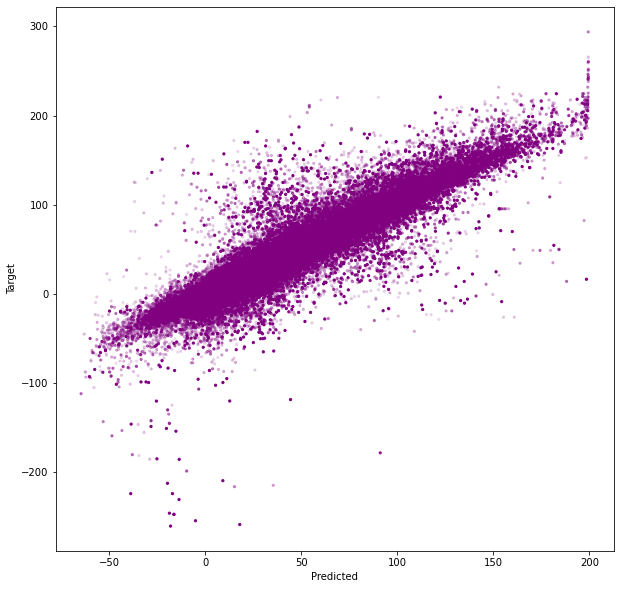

In [66]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e6

# plot points with transparency depending on size of trade
def drawpoints(preds, target, dataframe):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (10**dataframe.quantity > threshold/10)  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    
    print(f"Max prediction : {max(preds[keep])} Min predicton: {min(preds[keep])}")
    print(f"Length of dataframe: {len(dataframe)}")
    
    plt.figure(figsize=(10, 10))
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    plt.xlabel('Predicted')
    plt.ylabel('Target')

drawpoints(preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread

16.633716694637375
Max prediction : 9710.43621521426 Min predicton: -288.0888749979444
Length of dataframe: 555141


<Figure size 432x288 with 0 Axes>

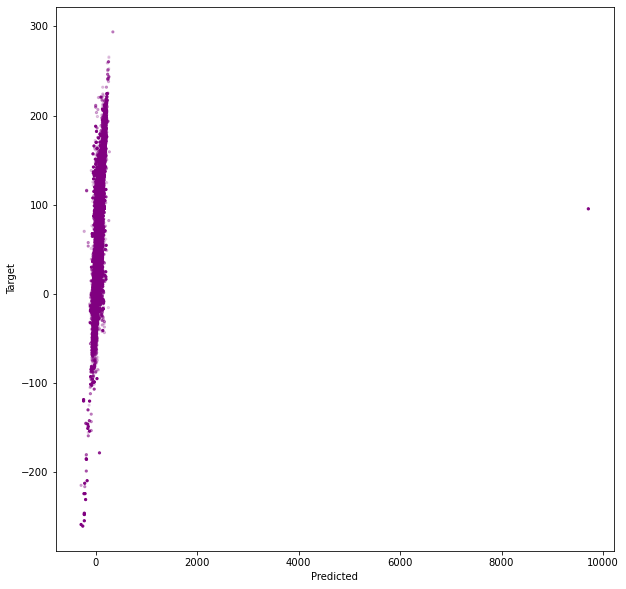

In [67]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

plt.figure()
drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread on dealer dealer true mid trades

11.471687694383272
Max prediction : 224.45460582602465 Min predicton: -224.0444373264511
Length of dataframe: 6193


<Figure size 432x288 with 0 Axes>

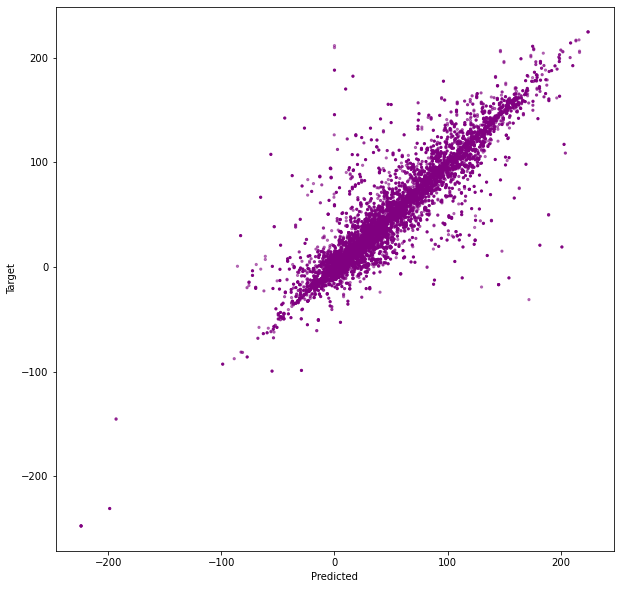

In [68]:
temp_test = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
last_ys_preds = temp_test.last_yield_spread
error = temp_test.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

plt.figure()
drawpoints(last_ys_preds, temp_test.yield_spread, temp_test)

### Regression baseline using previous yield spread optimizing MSE

In [69]:
from sklearn.linear_model import LinearRegression

In [70]:
x = train_dataframe.last_yield_spread.values.reshape(-1,1)
y = train_dataframe.yield_spread

In [71]:
reg = LinearRegression().fit(x, y)

In [72]:
print(f"Regression coefficient {reg.coef_} Intercept {reg.intercept_}")

Regression coefficient [0.79533689] Intercept 5.772009236679068


In [73]:
predicted_ys = reg.predict(test_dataframe.last_yield_spread.values.reshape(-1,1))
actual_ys = test_dataframe.yield_spread.values

In [74]:
MAE = np.mean(np.abs(test_dataframe.yield_spread - predicted_ys))
print(MAE)

16.58307420939522


In [75]:
x_range = np.arange(-20,300)
y_straight = x_range.copy()
y_regression = reg.coef_ * x_range + reg.intercept_

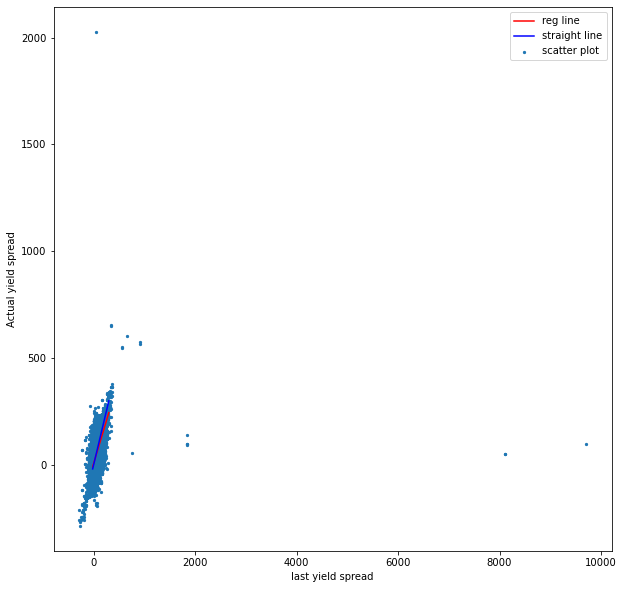

In [76]:
plt.figure(figsize=(10,10))
plt.scatter(test_dataframe.last_yield_spread, actual_ys, s=5)
plt.plot(x_range, y_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('Actual yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

In [77]:
test_dataframe[test_dataframe.yield_spread > 1000][['cusip','trade_date','purpose_sub_class','yield_spread']]

,cusip,trade_date,purpose_sub_class,yield_spread
174059,34682HPS9,2022-06-01,129.0,2026.866157


### Regression baseline using previous yield spread optimizing MAE

In [78]:
from statsmodels.regression.quantile_regression import QuantReg

In [79]:
q_reg = QuantReg(train_dataframe.last_yield_spread, train_dataframe.yield_spread)

In [80]:
res = q_reg.fit(q=.5)

In [81]:
predicted_yield_spread = res.predict(test_dataframe.last_yield_spread)
actual_yiels_spread = test_dataframe.yield_spread.values

In [82]:
MAE = np.mean(np.abs(actual_yiels_spread - predicted_yield_spread))
print(MAE)

16.633727960045192


In [83]:
print(f'Regression coefficient {res.params[0]}')

Regression coefficient 1.000000624325274


In [84]:
y_mae_regression = res.params[0] * x_range

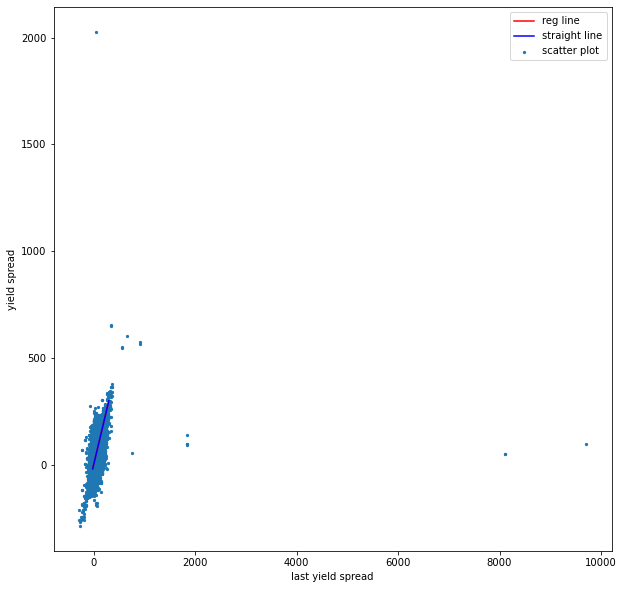

In [85]:
plt.figure(figsize=(10,10))
plt.scatter(test_dataframe.last_yield_spread, actual_yiels_spread, s=5)
plt.plot(x_range, y_mae_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

### LightGBM baseline

In [86]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features','yield_spread','calc_day_cat'])
    return df

In [87]:
trainlabel = train_dataframe.yield_spread
testlabel = test_dataframe.yield_spread

In [88]:
gbt_td = gbmprep(train_dataframe[PREDICTORS])

In [89]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [90]:
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [91]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(test_dataframe[PREDICTORS]) )
delta = testlabel - gbt_pred
print( delta.mean(), delta.abs().mean() )

-0.5702745954589951 13.996463294204634
CPU times: user 48.2 s, sys: 0 ns, total: 48.2 s
Wall time: 2.7 s


#### GBM true mid baseline

In [92]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(temp_test[PREDICTORS]) )
delta = temp_test.yield_spread - gbt_pred
print( delta.mean(), delta.abs().mean() )

-0.44804536109252496 13.83485860931933
CPU times: user 608 ms, sys: 0 ns, total: 608 ms
Wall time: 56.2 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

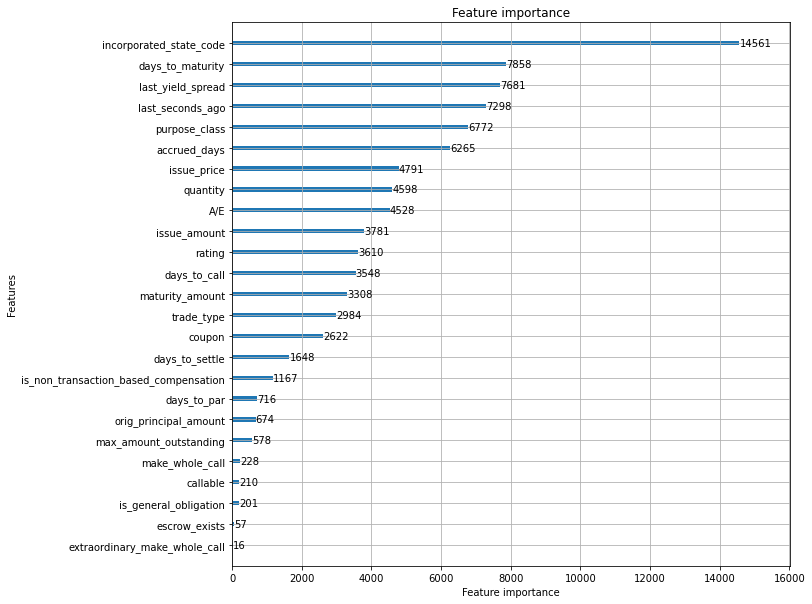

In [93]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10))

#### Analyzing the test set

In [94]:
test_preds = model.predict(x_test)

In [95]:
len(test_preds)

555141

In [96]:
evaluation_dataframe = test_dataframe.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [97]:
np.mean(evaluation_dataframe.delta_yield_spreads)

0.7919917152457336

In [98]:
np.std(evaluation_dataframe.delta_yield_spreads)

17.889125582836815

array([[<AxesSubplot:title={'center':'delta_yield_spreads'}>]],
      dtype=object)

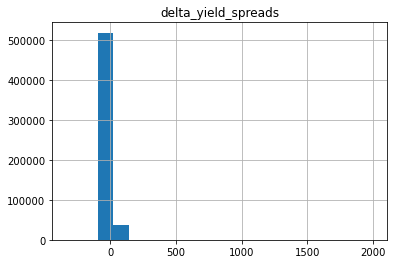

In [99]:
evaluation_dataframe.hist('delta_yield_spreads', bins=20)

In [100]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,concatenated_trade_history,predicted_yield_spreads,delta_yield_spreads
174059,2022060109442200,34682HPS9,False,False,False,False,False,False,False,False,...,66.549,2024-12-01,2022-06-01,2022-06-01 14:47:26,129.0,0.0,2,"[[55.31809038862369, 4.397940158843994, 0.0, 0...",34.565186,1992.300971
262536,2022052413984400,741530HK8,False,False,False,False,False,False,False,False,...,91.900,2024-11-01,2022-05-24,2022-05-24 16:34:04,129.0,0.0,2,"[[341.825321608874, 4.176091194152832, 0.0, 0....",199.003189,455.895710
262535,2022052413984800,741530HK8,False,False,False,False,False,False,False,False,...,92.000,2024-11-01,2022-05-24,2022-05-24 16:34:04,129.0,0.0,2,"[[341.825321608874, 4.176091194152832, 0.0, 0....",199.117813,450.881086
230526,2022052603852700,741530HK8,False,False,False,False,False,False,False,False,...,93.500,2024-11-01,2022-05-26,2022-05-26 11:19:38,129.0,0.0,2,"[[649.9988989539306, 4.778151035308838, 0.0, 0...",199.381851,401.950487
142257,2022060211819500,741530HJ1,False,False,False,False,False,False,False,False,...,96.750,2023-11-01,2022-06-02,2022-06-02 15:45:14,129.0,0.0,2,"[[922.6606084186361, 4.397940158843994, 0.0, 0...",198.320206,374.225793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11636,2022061004120500,914455UJ7,True,False,False,False,False,False,False,True,...,93.851,2122-04-01,2022-06-10,2022-06-10 12:05:48,87.0,0.0,2,"[[-258.81322835451647, 4.301030158996582, 0.0,...",7.468403,-252.981631
684764,2022050606395600,748508A24,False,False,False,True,True,False,False,False,...,103.048,2026-12-15,2022-05-06,2022-05-06 12:34:53,0.0,0.0,2,"[[74.77641694049427, 6.006465911865234, 0.0, 1...",91.099525,-269.436508
352279,2022052001755900,914455UJ7,True,False,False,False,False,False,False,True,...,91.410,2122-04-01,2022-05-20,2022-05-20 09:59:53,87.0,0.0,2,"[[-260.46588281305424, 6.24551248550415, 1.0, ...",8.199818,-275.610684
290433,2022052402103800,914455UJ7,True,False,False,False,False,False,False,True,...,94.174,2122-04-01,2022-05-24,2022-05-24 10:00:49,87.0,0.0,2,"[[-288.0888749979444, 4.301030158996582, 0.0, ...",17.935186,-276.648887


#### Isolating trades with error greater than 50 bps

In [101]:
evaluation_dataframe['delta_last_yield_spread'] = np.abs(evaluation_dataframe.yield_spread - evaluation_dataframe.last_yield_spread)

In [102]:
temp_50 = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 20) | (evaluation_dataframe.delta_yield_spreads < -20)  ]
temp_50 = temp_50.sort_values('delta_yield_spreads',ascending=False)
display(temp_50)
temp_50.to_csv('greater_than_20.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,concatenated_trade_history,predicted_yield_spreads,delta_yield_spreads,delta_last_yield_spread
174059,2022060109442200,34682HPS9,False,False,False,False,False,False,False,False,...,2024-12-01,2022-06-01,2022-06-01 14:47:26,129.0,0.0,2,"[[55.31809038862369, 4.397940158843994, 0.0, 0...",34.565186,1992.300971,1971.548066
262536,2022052413984400,741530HK8,False,False,False,False,False,False,False,False,...,2024-11-01,2022-05-24,2022-05-24 16:34:04,129.0,0.0,2,"[[341.825321608874, 4.176091194152832, 0.0, 0....",199.003189,455.895710,313.073577
262535,2022052413984800,741530HK8,False,False,False,False,False,False,False,False,...,2024-11-01,2022-05-24,2022-05-24 16:34:04,129.0,0.0,2,"[[341.825321608874, 4.176091194152832, 0.0, 0....",199.117813,450.881086,308.173577
230526,2022052603852700,741530HK8,False,False,False,False,False,False,False,False,...,2024-11-01,2022-05-26,2022-05-26 11:19:38,129.0,0.0,2,"[[649.9988989539306, 4.778151035308838, 0.0, 0...",199.381851,401.950487,48.666560
142257,2022060211819500,741530HJ1,False,False,False,False,False,False,False,False,...,2023-11-01,2022-06-02,2022-06-02 15:45:14,129.0,0.0,2,"[[922.6606084186361, 4.397940158843994, 0.0, 0...",198.320206,374.225793,350.114610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11636,2022061004120500,914455UJ7,True,False,False,False,False,False,False,True,...,2122-04-01,2022-06-10,2022-06-10 12:05:48,87.0,0.0,2,"[[-258.81322835451647, 4.301030158996582, 0.0,...",7.468403,-252.981631,13.300000
684764,2022050606395600,748508A24,False,False,False,True,True,False,False,False,...,2026-12-15,2022-05-06,2022-05-06 12:34:53,0.0,0.0,2,"[[74.77641694049427, 6.006465911865234, 0.0, 1...",91.099525,-269.436508,253.113399
352279,2022052001755900,914455UJ7,True,False,False,False,False,False,False,True,...,2122-04-01,2022-05-20,2022-05-20 09:59:53,87.0,0.0,2,"[[-260.46588281305424, 6.24551248550415, 1.0, ...",8.199818,-275.610684,6.944984
290433,2022052402103800,914455UJ7,True,False,False,False,False,False,False,True,...,2122-04-01,2022-05-24,2022-05-24 10:00:49,87.0,0.0,2,"[[-288.0888749979444, 4.301030158996582, 0.0, ...",17.935186,-276.648887,29.375174


Top 20 trades that cause the biggest errors. All the biggest erros come from Dealer Sell trade type

In [103]:
temp_50[['rtrs_control_number','cusip','trade_type','quantity','trade_date','yield_spread','last_yield_spread','delta_yield_spreads','delta_last_yield_spread']][:20]

,rtrs_control_number,cusip,trade_type,quantity,trade_date,yield_spread,last_yield_spread,delta_yield_spreads,delta_last_yield_spread
174059,2022060109442200,34682HPS9,D,25000.007812,2022-06-01,2026.866157,55.318090,1992.300971,1971.548066
262536,2022052413984400,741530HK8,P,60000.035156,2022-05-24,654.898899,341.825322,455.895710,313.073577
262535,2022052413984800,741530HK8,D,60000.035156,2022-05-24,649.998899,341.825322,450.881086,308.173577
230526,2022052603852700,741530HK8,S,49999.980469,2022-05-26,601.332339,649.998899,401.950487,48.666560
142257,2022060211819500,741530HJ1,D,10000.000000,2022-06-02,572.545999,922.660608,374.225793,350.114610
141959,2022060211806400,741530HJ1,S,10000.000000,2022-06-02,564.745999,922.660608,366.243802,357.914610
141581,2022060212012200,741530HJ1,D,14999.998047,2022-06-02,553.045999,564.745999,354.713968,11.700000
141582,2022060212006000,741530HJ1,S,14999.998047,2022-06-02,545.245999,564.745999,346.468975,19.500000
267850,2022052411468000,546415T42,S,100000.000000,2022-05-24,250.496653,-2.303347,267.596592,252.800000
283839,2022052404801600,452152YJ4,P,100000.000000,2022-05-24,280.850070,261.083517,218.930084,19.766553


#### Isolating trades with error less than 3 bps

In [104]:
temp_3 = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads < 3) & (evaluation_dataframe.delta_yield_spreads > -3)  ]
temp_3 = temp_3.sort_values('delta_last_yield_spread',ascending=False)
display(temp_3)
temp_3.to_csv('less_than_3.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,concatenated_trade_history,predicted_yield_spreads,delta_yield_spreads,delta_last_yield_spread
360747,2022051913243200,797355WH3,False,False,False,False,True,False,False,False,...,2024-07-01,2022-05-19,2022-05-19 15:41:02,51.0,0.0,2,"[[-125.4509262039182, 4.301030158996582, 1.0, ...",30.513868,-0.876813,155.087982
186337,2022060103442400,93974DCA4,True,False,False,False,False,False,False,False,...,2023-08-01,2022-06-01,2022-06-01 11:17:21,32.0,0.0,0,"[[-125.23457512768331, 4.0, 0.0, 1.0, 5.770670...",27.384764,-0.006740,152.612599
27935,2022060908343100,59261AJK4,False,False,False,False,False,False,False,False,...,2024-11-15,2022-06-09,2022-06-09 14:11:05,17.0,0.0,2,"[[211.92558232771194, 4.0, 1.0, 0.0, 5.8905735...",66.071716,2.674402,143.179464
349202,2022052003069600,649451FN6,False,False,False,False,False,False,False,False,...,2024-11-15,2022-05-20,2022-05-20 10:42:19,103.0,0.0,2,"[[247.14211212893088, 4.176091194152832, 0.0, ...",104.165306,0.797666,142.179140
11255,2022061004295100,64966MRD3,True,False,False,False,True,False,False,False,...,2041-10-01,2022-06-10,2022-06-10 12:13:29,0.0,0.0,2,"[[172.0660315908587, 4.698969841003418, 0.0, 1...",30.437077,2.150687,139.478268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247009,2022052507176900,64971WQ86,False,False,False,False,False,False,False,False,...,2026-08-01,2022-05-25,2022-05-25 12:49:58,17.0,0.0,2,"[[25.568398784735933, 4.397940158843994, 0.0, ...",28.541239,-2.972840,0.000000
658167,2022050905820700,796269VR6,True,False,False,False,True,False,False,False,...,2025-02-15,2022-05-09,2022-05-09 12:35:00,34.0,0.0,0,"[[21.38970696265062, 4.0, 0.0, 0.0, 1.78532983...",22.482918,-1.093211,0.000000
485676,2022051608287700,91412GYH2,False,False,False,False,False,False,False,False,...,2024-05-15,2022-05-16,2022-05-16 13:27:10,87.0,0.0,2,"[[3.5239987447708074, 5.176091194152832, 0.0, ...",6.064287,-2.540288,0.000000
549200,2022051208560600,914353L39,True,False,False,False,False,False,False,False,...,2035-04-01,2022-05-12,2022-05-12 13:26:56,87.0,0.0,2,"[[70.39122688565965, 4.176091194152832, 0.0, 0...",68.485031,1.906196,0.000000
